## Configuración de ambiente

In [4]:
!nvidia-smi

Mon Dec  5 00:52:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [5]:
!pip install "monai[einops]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.7 MB/s eta 0:00:00


In [6]:
!pip --version

pip 22.1.2 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)


In [7]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [8]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.0.1
Numpy version: 1.21.6
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.1.1
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.3.5
einops version: 0.6.0
transformers version: 4.20.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Directorio de datos de configuración

Puede especificar un directorio con la variable de entorno `MONAI_DATA_DIRECTORY`.
Esto le permite guardar los resultados y reutilizar las descargas.
Si no se especifica, se utilizará un directorio temporal.


In [10]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpphqvzl1x


## Cálculo promedio, lector de pliegues, protector de punto de control

In [11]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):

    with open(datalist) as f:
        json_data = json.load(f)
    json_data = json_data[key]
    for d in json_data:
        for k, v in d.items():
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]
    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)
    return tr, val

def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

## Configuración de Dataloader

In [12]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(
        datalist=datalist_json, basedir=data_dir, fold=fold
    )
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)
    print(len(train_files))
    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    print(len(validation_files))
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    return train_loader, val_loader

## Establecer el directorio raíz del conjunto de datos y los hiperparámetros



In [39]:
data_dir = "/kaggle/input/brats2021-sub-data/BraTS2021_Training_Data_Sub"
json_list = "/kaggle/input/dataSwinUnet/brats21_folds_e.json"

roi = (128, 128, 128)
batch_size = 2
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 10
# roi = (128, 128, 128)
# batch_size = 1
# sw_batch_size = 1
# fold = 1
# infer_overlap = 0.5
# max_epochs = 100
# val_every = 10
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

100
25


In [14]:
x= next(iter(train_loader))
y= x.get(0)
print(f'y shape={type(y)} dtype={y}')

y shape=<class 'NoneType'> dtype=None


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


## Visualización de los datos y vista

(240, 240, 155) (240, 240, 155)
image shape: (240, 240, 155), label shape: (240, 240, 155)


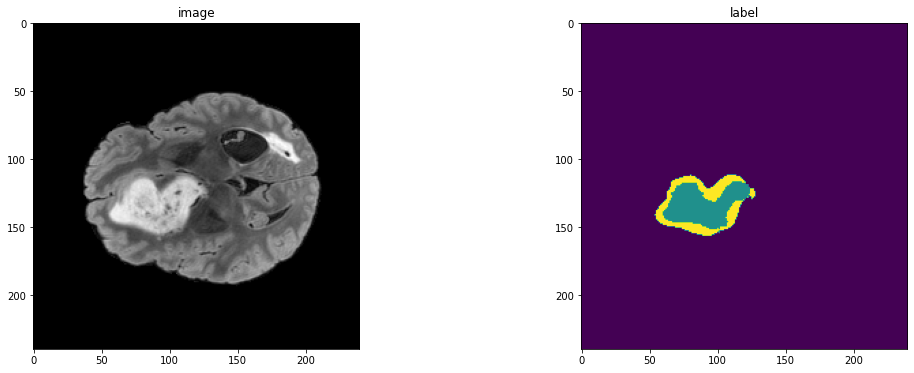

In [15]:
slice_num = 67
img_add = os.path.join(
    data_dir, "BraTS2021_00012/BraTS2021_00012_flair.nii"
)
label_add = os.path.join(
    data_dir, "BraTS2021_00012/BraTS2021_00012_seg.nii"
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(img.shape, label.shape)

print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.show()

## Crear modelo Swin UNETR

En esta escena, creamos el modelo Swin UNETR para la segmentación semántica de tumores cerebrales de 3 clases. Usamos un tamaño de característica de 48. También usamos puntos de control de gradiente para un entrenamiento más eficiente de la memoria. 

In [40]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
#     img_size=roi,
#     in_channels=4,
#     out_channels=3,
#     feature_size=12,
#     drop_rate=0.0,
#     attn_drop_rate=0.0,
#     dropout_path_rate=0.0,
#     use_checkpoint=True,
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
).to(device)

## Optimizador y función de pérdida

In [17]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(
    include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True
)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

## Definición entenamiento y validación por época

In [18]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(
                device
            )
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [
                post_pred(post_sigmoid(val_pred_tensor))
                for val_pred_tensor in val_outputs_list
            ]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            Dice_TC = run_acc.avg[0]
            Dice_WT = run_acc.avg[1]
            Dice_ET = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", Dice_TC:",
                Dice_TC,
                ", Dice_WT:",
                Dice_WT,
                ", Dice_ET:",
                Dice_ET,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

## Entrenamiento

In [19]:
from itertools import islice as take
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):

    val_acc_max = 0.0
    Dices_TC = []
    Dices_WT = []
    Dices_ET = []
    Dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            Dice_TC = val_acc[0]
            Dice_WT = val_acc[1]
            Dice_ET = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", Dice_TC:",
                Dice_TC,
                ", Dice_WT:",
                Dice_WT,
                ", Dice_ET:",
                Dice_ET,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            Dices_TC.append(Dice_TC)
            Dices_WT.append(Dice_WT)
            Dices_ET.append(Dice_ET)
            Dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        Dices_TC,
        Dices_WT,
        Dices_ET,
        Dices_avg,
        loss_epochs,
        trains_epoch,
    )

## Ejecución del modelo

In [18]:
start_epoch = 0

(
    val_acc_max,
    Dices_TC,
    Dices_WT,
    Dices_ET,
    Dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Sun Dec  4 17:25:09 2022 Epoch: 0
Epoch 0/100 0/100 loss: 0.9346 time 25.41s
Epoch 0/100 1/100 loss: 0.9610 time 1.32s
Epoch 0/100 2/100 loss: 0.9725 time 1.28s
Epoch 0/100 3/100 loss: 0.9773 time 1.30s
Epoch 0/100 4/100 loss: 0.9612 time 1.30s
Epoch 0/100 5/100 loss: 0.9628 time 1.50s
Epoch 0/100 6/100 loss: 0.9649 time 1.32s
Epoch 0/100 7/100 loss: 0.9553 time 1.31s
Epoch 0/100 8/100 loss: 0.9529 time 1.31s
Epoch 0/100 9/100 loss: 0.9508 time 1.43s
Epoch 0/100 10/100 loss: 0.9527 time 1.35s
Epoch 0/100 11/100 loss: 0.9545 time 1.29s
Epoch 0/100 12/100 loss: 0.9565 time 1.38s
Epoch 0/100 13/100 loss: 0.9556 time 1.34s
Epoch 0/100 14/100 loss: 0.9541 time 1.32s
Epoch 0/100 15/100 loss: 0.9570 time 1.32s
Epoch 0/100 16/100 loss: 0.9563 time 1.35s
Epoch 0/100 17/100 loss: 0.9582 time 1.51s
Epoch 0/100 18/100 loss: 0.9604 time 1.41s
Epoch 0/100 19/100 loss: 0.9614 time 1.75s
Epoch 0/100 20/100 loss: 0.9582 time 1.40s
Epoch 0/100 21/100 loss: 0.9594 time 1.33s
Epoch 0/100 22/100 loss: 0.95

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Val 0/100 0/25 , Dice_TC: 0.0045072795 , Dice_WT: 0.32881317 , Dice_ET: 0.064823404 , time 15.33s
Val 0/100 1/25 , Dice_TC: 0.014849225 , Dice_WT: 0.27840343 , Dice_ET: 0.124145426 , time 6.57s
Val 0/100 2/25 , Dice_TC: 0.012769055 , Dice_WT: 0.2195363 , Dice_ET: 0.10991471 , time 6.45s
Val 0/100 3/25 , Dice_TC: 0.016119203 , Dice_WT: 0.23637232 , Dice_ET: 0.15584566 , time 6.45s
Val 0/100 4/25 , Dice_TC: 0.013186568 , Dice_WT: 0.19300969 , Dice_ET: 0.12841019 , time 6.45s
Val 0/100 5/25 , Dice_TC: 0.013467875 , Dice_WT: 0.1887945 , Dice_ET: 0.14216368 , time 6.44s
Val 0/100 6/25 , Dice_TC: 0.011606464 , Dice_WT: 0.16778274 , Dice_ET: 0.122797 , time 6.43s
Val 0/100 7/25 , Dice_TC: 0.010283201 , Dice_WT: 0.16010347 , Dice_ET: 0.10993282 , time 6.43s
Val 0/100 8/25 , Dice_TC: 0.0114340205 , Dice_WT: 0.17077425 , Dice_ET: 0.16061896 , time 6.43s
Val 0/100 9/25 , Dice_TC: 0.010542725 , Dice_WT: 0.16619554 , Dice_ET: 0.14866686 , time 6.42s
Val 0/100 10/25 , Dice_TC: 0.010678067 , Dice_WT:

In [20]:

# !cp -r /tmp/tmpaw5e_03b/model.pt /kaggle/working
# 
# state_dict = model.state_dict()
# save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
# filename = os.path.join(dir_add, filename)
# torch.save(model.state_dict(), "/kaggle/working/model.pt")


# x, y = next(iter(train_loader))
# print(f'x shape={x.shape} dtype={x.dtype}')
# print(f'y shape={y.shape} dtype={y.dtype}')

# a,b = take(train_loader,None)
# print(a,b )/kaggle/working/tmp/tmpaw5e_03b/model.pt

In [20]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

train completed, best average dice: 0.8584 


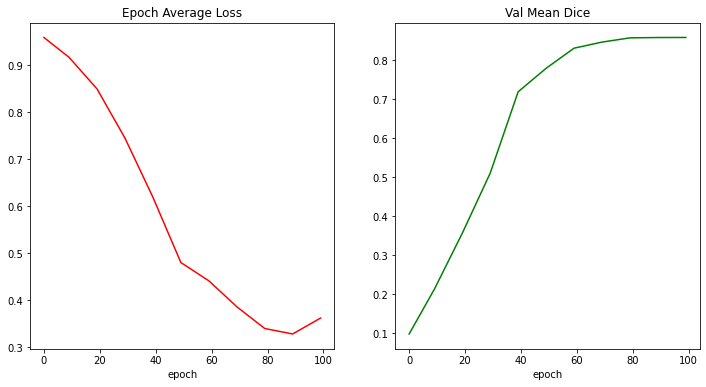

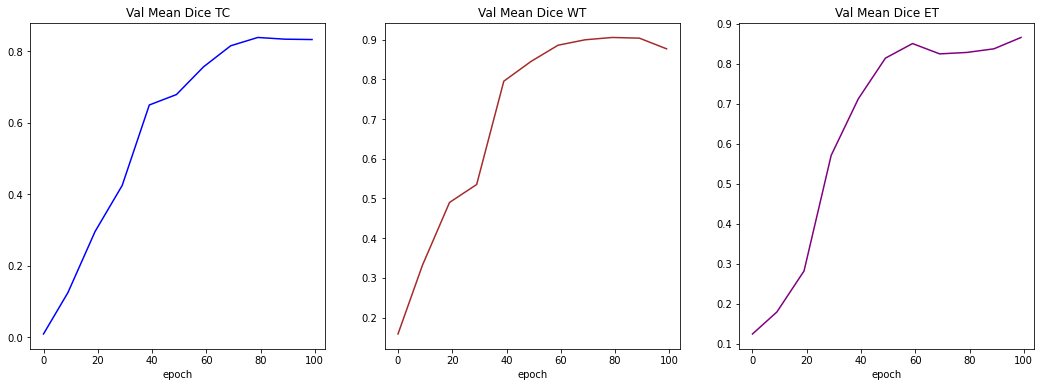

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_TC, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_WT, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, Dices_ET, color="purple")
plt.show()

## Cálculo de predicciones

In [21]:
case_num = "00343"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_t1ce.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_t1.nii",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_"
                + case_num
                + "/BraTS2021_"
                + case_num
                + "_t2.nii",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "BraTS2021_"
            + case_num
            + "/BraTS2021_"
            + case_num
            + "_seg.nii",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
model.load_state_dict(torch.load(os.path.join("/kaggle/input/dataSwinUnet", "model.pt"))["state_dict"])

model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

## Visualización de predicciones

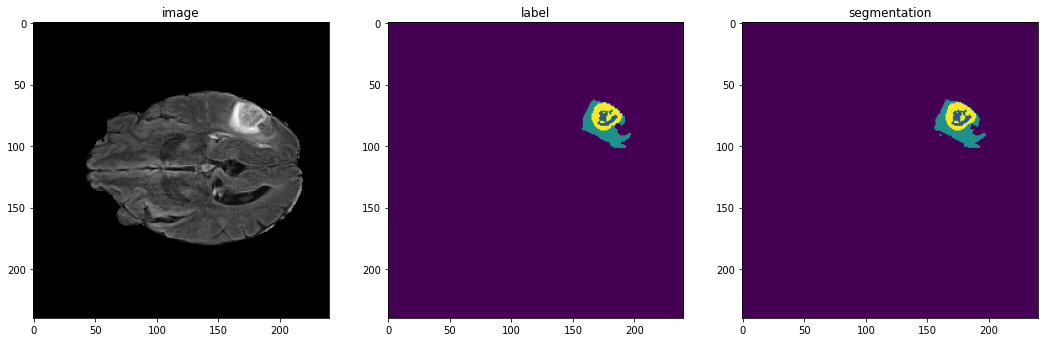

In [42]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii",
)
label_add = os.path.join(
    data_dir,
    "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii",
)
seg_out1=label
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

In [25]:
if directory is None:
    shutil.rmtree(root_dir)